In [153]:
import pandas as pd
import numpy as np
import plotly.graph_objects as go
import matplotlib.pyplot as plt

In [154]:
df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/RRM026/Day151/RRM026_Day151_R1_tracks_processed.csv')
trial_df = pd.read_csv('/Users/yang/Documents/Wilbrecht_Lab/data/processed_tracks/trial_df.csv')
frames_preserved = 32

In [155]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import logging


class PlotlyFig:
    # TODO: add automatic color palette

    def __init__(
        self, rows=1, cols=1, shared_xaxes=True, vertical_spacing=0.1, **kwargs
    ):
        fig = make_subplots(
            rows=rows,
            cols=cols,
            shared_xaxes=shared_xaxes,
            vertical_spacing=vertical_spacing,
            **kwargs,
        )
        self.fig = fig

    def plot(
        self, x, y, name="", color="blue", mode="lines+markers", row=1, col=1, **kwargs
    ):
        self.fig.add_trace(
            go.Scatter(x=x, y=y, mode=mode, name=name, line=dict(color=color)),
            row=row,
            col=col,
        )

    def show(self):
        self.fig.show()

In [156]:
from scipy import stats
# def foaw_smooth(trial_df, sr, noise_max):
#     trial_df = trial_df.reset_index()
#     trial_df['smoothed velocity x'] = foaw(trial_df['warped Head x'], sr, noise_max, n=16, best=False)
#     trial_df['smoothed velocity y'] = foaw(trial_df['warped Head y'], sr, noise_max, n=16, best=False)
#     return trial_df

def plot_trial(trial_df, a, b=None):
    plt.plot(trial_df[a], label=a, color='blue', alpha=0.3)
    if b is not None:
        plt.plot(trial_df[b], label=b, color='red', alpha=0.3)

def get_subjective_angular_velocity(trial_df, sr):
    """
    Calculate the angular velocities based on neck-head orientation and head velocity changes.
    
    Parameters:
    trial_df (pd.DataFrame): DataFrame containing the time series data with columns for Neck x, Neck y, Head x, and Head y.
    sr (float): Sampling rate.
    
    Returns:
    pd.DataFrame: DataFrame with calculated angular velocities and their sum.
    """
    # Calculate the neck-head orientation angles
    neck_head_angles = np.arctan2(trial_df['warped Head y'] - trial_df['warped Neck y'], trial_df['warped Head x'] - trial_df['warped Neck x'])
    neck_head_angles_unwrapped = np.unwrap(neck_head_angles)
    rotation = np.gradient(neck_head_angles_unwrapped) * sr
    
    # Calculate the head velocity
    head_velocity_x = np.gradient(trial_df['warped Head x']) * sr
    head_velocity_y = np.gradient(trial_df['warped Head y']) * sr
    
    # Calculate VTE
    dx = np.gradient(trial_df['warped Head x'])
    dy = np.gradient(trial_df['warped Head y'])
    Phi = np.unwrap(np.arctan2(dy, dx))
    dPhi = np.abs(np.gradient(Phi))
    
    # Calculate the head velocity angles
    head_velocity_angles = np.arctan2(head_velocity_y, head_velocity_x)
    head_velocity_angles_unwrapped = np.unwrap(head_velocity_angles)
    revolution = np.gradient(head_velocity_angles_unwrapped) * sr
    
    rotation = stats.zscore(rotation)
    revolution = stats.zscore(revolution)
    
    # Calculate the sum of the two angular velocities
    subjective_angular_velocity = rotation + revolution
    
    trial_df['Head_vx'] = head_velocity_x
    trial_df['Head_vy'] = head_velocity_y
    trial_df['Neck_Head_x'] = trial_df['warped Head x'] - trial_df['warped Neck x']
    trial_df['Neck_Head_y'] = trial_df['warped Head y'] - trial_df['warped Neck y']
    trial_df['Neck_Head_angles'] = neck_head_angles_unwrapped
    trial_df['Head_v_angles'] = head_velocity_angles_unwrapped
    trial_df['rotation'] = rotation
    trial_df['revolution'] = revolution
    trial_df['angular_velocity'] = subjective_angular_velocity
    trial_df['dPhi'] = dPhi
    
    return trial_df

In [157]:
from scipy.stats import linregress

def calculate_straight_walking_features(segment):
    if len(segment) < 2:
        return np.nan, np.nan
    straight_walking_speed = segment['Head_v'].mean()
    x_coords = segment['warped Head x'].values
    y_coords = segment['warped Head y'].values
    if len(x_coords) < 2:
        return straight_walking_speed, np.nan
    slope, _, _, _, _ = linregress(y_coords, x_coords) # Switch x and y
    return straight_walking_speed, slope

def get_REJ_features(trial_df):
    last_x = trial_df['warped Head x'].iloc[-1]
    last_y = trial_df['warped Head y'].iloc[-1]
    
    return last_x, last_y

def get_features_per_trial(trial_df, frames_preserved=32):
    trial_df = trial_df.reset_index(drop=True)
    sleap_decision = trial_df['decision'].dropna().iloc[-1] if not trial_df['decision'].dropna().empty else np.nan
    bonsai_decision = trial_df['label'].dropna().iloc[-1] if not trial_df['label'].dropna().empty else np.nan
    animal = trial_df['animal'].iloc[0]
    session = trial_df['session'].iloc[0]
    restaurant = trial_df['restaurant'].iloc[0]
    trial_length = len(trial_df)
    
    coords = trial_df[['warped Head x', 'warped Head y']].head(frames_preserved).values.flatten()
    if len(coords) < frames_preserved * 2:
        coords = np.pad(coords, (0, frames_preserved * 2 - len(coords)), 'constant', constant_values=np.nan)
    coords_dict = {f'x{i // 2 + 1}' if i % 2 == 0 else f'y{i // 2 + 1}': coords[i] for i in range(len(coords))}
    
    # Identify each segments
    t_entry_idx = trial_df[trial_df['decision'] == 'T_Entry'].index[0]
    decision_idx = trial_df[(trial_df['decision'] == 'ACC') | (trial_df['decision'] == 'REJ')].index[0]
    straight_walking_segment = trial_df.iloc[:t_entry_idx+1]
    turning_segment = trial_df.iloc[t_entry_idx:decision_idx+1]
    VTE_segment = trial_df.iloc[:decision_idx+1]
    
    straight_walking_speed, straight_walking_slope = calculate_straight_walking_features(straight_walking_segment)
    average_angular_velocity = turning_segment['angular_velocity'].mean()
    Vte = VTE_segment['dPhi'].sum()
    last_x, last_y = get_REJ_features(trial_df)
    
    result = pd.Series({
        **coords_dict,
        'sleap_decision': sleap_decision,
        'bonsai_decision': bonsai_decision,
        'animal': animal,
        'session': session,
        'restaurant': restaurant,
        'trial_length': trial_length,
        'straight_walking_speed': straight_walking_speed,
        'straight_walking_slope': straight_walking_slope,
        'average_angular_velocity': average_angular_velocity,
        'VTE': Vte,
        'last_x': last_x,
        'last_y': last_y
    })
    
    return result

In [158]:
sr = 30
noise_max = 0.1
decision = 'ACC'

df_omega = df.groupby('trial', group_keys=True).apply(get_subjective_angular_velocity, sr=sr).reset_index(drop=True)

trial_df = trial_df[(trial_df['animal'] == 'RRM026') & (trial_df['session'] == 'Day151') & (trial_df['sleap_decision'] == decision)]

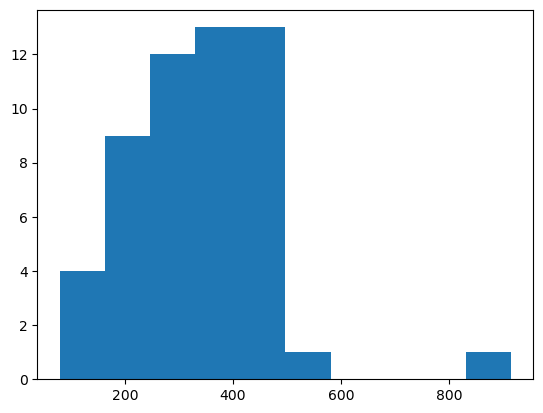

In [159]:
plt.hist(trial_df['straight_walking_speed'])
trial_df['straight_walking_speed'].describe()
trial_df = trial_df[(trial_df['straight_walking_speed'] > 344) & (trial_df['straight_walking_speed'] < 500)]

In [160]:
fast_df = df_omega[df_omega['trial'].isin(trial_df['trial'])]

In [175]:
df_omega['trial'].drop_duplicates()

0        1
37       5
83       8
142     12
209     16
258     20
308     24
462     28
513     32
561     36
612     40
678     44
887     48
935     52
1380    56
1485    60
1537    64
1599    68
1671    72
Name: trial, dtype: int64

In [188]:
sr = 30
noise_max = 0.1

plot_df = df_omega[df_omega['trial'] == 20]

pfig = PlotlyFig(rows=6, cols=1, shared_xaxes=True)
pfig.plot(plot_df['rel_time'], plot_df['angular_velocity'], color='red', mode='lines', row=1, col=1, name='angular_velocity')
pfig.plot(plot_df['rel_time'], plot_df['Neck_Head_angles'], color='green', mode='lines', row=2, col=1, name='Neck_Head_angles')
pfig.plot(plot_df['rel_time'], plot_df['rotation'], color='black', mode='lines', row=3, col=1, name='rotation')
pfig.plot(plot_df['rel_time'], plot_df['Head_v_angles'], color='yellow', mode='lines', row=4, col=1, name='Head_v_angles')
pfig.plot(plot_df['rel_time'], plot_df['revolution'], color='blue', mode='lines', row=5, col=1, name='revolution')
pfig.plot(plot_df['rel_time'], plot_df['dPhi'], color='purple', mode='lines', row=6, col=1, name='dPhi')

dec_time = plot_df[plot_df['decision'].isin(['ACC', 'REJ'])]['rel_time'].values
tentry_time = plot_df[plot_df['decision'] == 'T_Entry']['rel_time'].values
if dec_time:
    pfig.fig.add_vline(x=dec_time[0], line=dict(color='green'))
if tentry_time:
    pfig.fig.add_vline(x=tentry_time[0], line=dict(color='green'))
pfig.fig.update_layout(height=200*5)

pfig.show()

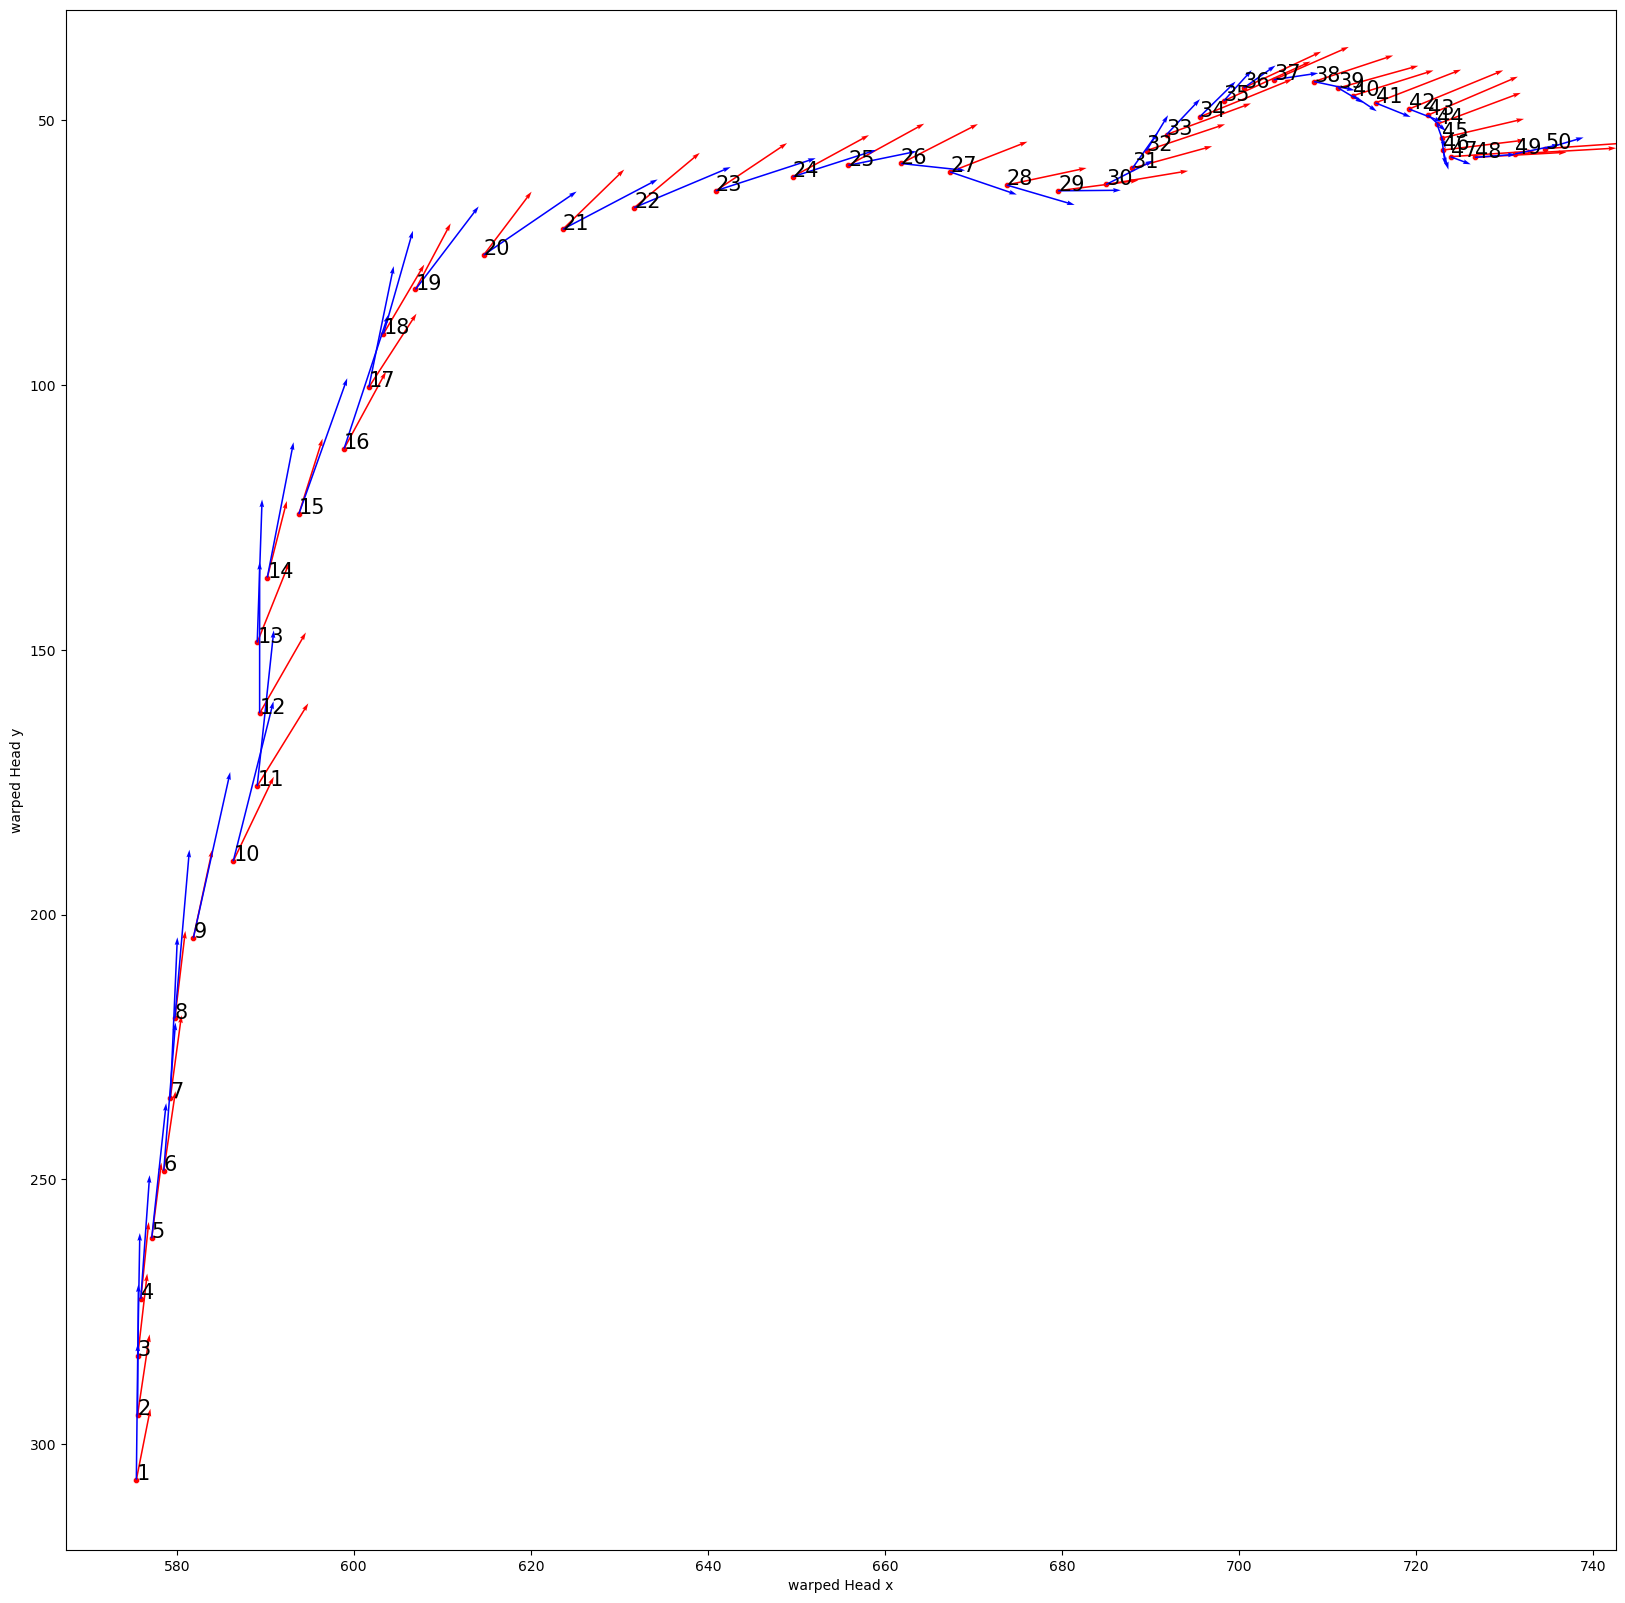

In [189]:
from scipy.special import expit
import seaborn as sns

beta=1/2

head_neck_x = plot_df['Neck_Head_x']
head_neck_y = plot_df['Neck_Head_y']
#head_vx = expit(beta*plot_df['Head velocity x'].values) - 0.5
#head_vy = expit(beta*plot_df['Head velocity y'].values) - 0.5
#head_vx = plot_df['Head velocity x'].values
#head_vy = plot_df['Head velocity y'].values
head_vx = plot_df['Head_vx']
head_vy = plot_df['Head_vy']

fig = plt.figure(figsize=(20, 20))
ax = plt.gca()
sns.scatterplot(data=plot_df, x='warped Head x', y='warped Head y', color='r', s=20)
# sns.scatterplot(data=plot_df[(plot_df['rel_time'] >=1.30) & (plot_df['rel_time'] <= 1.60)], x='warped Neck x', y='warped Neck y', color='r', s=20)
ax.quiver(plot_df['warped Head x'], plot_df['warped Head y'], head_neck_x, -head_neck_y, color='r', width=0.001)
ax.quiver(plot_df['warped Head x'], plot_df['warped Head y'], head_vx, -head_vy, color='b', width=0.001)
for i in range(len(plot_df)):
    # if i >= 33:
    ax.text(plot_df['warped Head x'].iat[i], plot_df['warped Head y'].iat[i], i+1, fontsize=15)
# ax.set_xlim((340, 360))
# ax.set_ylim((18, 24))
ax.invert_yaxis()
# ax.axvline(1.47, c='k', ls='--')